## Description

This kernel is a continuation of my previous kernels and is aimed at creating a huge number of features, which were invented in different public kernels (including mine). Please notice, that high number of available features doesn't mean that using all of them at once is a good idea :) Feature selection should be used to limit the number of features.

Another important point: some of the code for feature creation is commented, because otherwise kernel hits time limit. I generated these features locally and created a dataset with them: https://www.kaggle.com/artgor/lanl-features

Also I wrote another kernel to show various model interpretation and feature selection technics: https://www.kaggle.com/artgor/feature-selection-model-interpretation-and-more

Importing libraries.

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns

from numpy.fft import *
import pywt 

import scipy
from scipy import stats
from scipy import signal
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy.signal import butter, deconvolve

from statsmodels.robust import mad

from sklearn.kernel_ridge import KernelRidge
from itertools import product

from tsfresh.feature_extraction import feature_calculators
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

/Users/Sphinx/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Feature generation

At first I want to aknowledge these kernels and use features/ideas from them:
* fft features from  https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction
* some changes to code of feature generation inspired by https://www.kaggle.com/arkaung/earthquakes-over-feature-engineering-lightgbm
* tsfresh and some other features from https://www.kaggle.com/abhishek/quite-a-few-features-1-51/data I also use the class from this kernel, it is really great!

## Preparing functions

In [2]:
# Create a training file with simple derived features

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

In [5]:
# lanl-earthquake-prediction-signal-denoising
# SIGNAL_LEN = 150000
SAMPLE_RATE = 4000

def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def high_pass_filter(x, low_cutoff=10000, SAMPLE_RATE=4000000):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    x: 1サンプル分のデータ (150000,)
    """
    
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * SAMPLE_RATE
    norm_low_cutoff = low_cutoff / nyquist
    
    # Fault pattern usually exists in high frequency band. According to literature, the pattern is visible above 10^4 Hz.
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)

    return filtered_sig

def denoise_signal(x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    x: 1サンプル分のデータ (150000,)
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per")
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest(coeff[-level])

    # Calculate the univeral threshold
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

def denoise_and_high_pass_filter(x, low_cutoff=10000, SAMPLE_RATE=4000000):
    """
    x: 1サンプル分のデータ (150000,)
    """
    return denoise_signal(high_pass_filter(x, low_cutoff=low_cutoff, SAMPLE_RATE=SAMPLE_RATE))

### Main class for feature generation

From abhishek kernel

In [29]:
chunk_size=150000

class FeatureGenerator(object):
    def __init__(self, dtype, n_jobs=1, chunk_size=150000):
        self.chunk_size = chunk_size
        self.dtype = dtype
        self.filename = None
        self.n_jobs = n_jobs
        self.test_files = []
        if self.dtype == 'train':
            self.filename = '../input/train.csv'
            self.total_data = int(629145481 / self.chunk_size)
        else:
            submission = pd.read_csv('../input/sample_submission.csv')
            for seg_id in submission.seg_id.values:
                self.test_files.append((seg_id, '../input/test/' + seg_id + '.csv'))
            self.total_data = int(len(submission))

    def read_chunks(self):
        """
        150000行ごとにひとかたまりとしてデータを読み込む
        """
        if self.dtype == 'train':
            iter_df = pd.read_csv(self.filename, iterator=True, chunksize=self.chunk_size,
                                  dtype={'acoustic_data': np.float64, 'time_to_failure': np.float64})
            for counter, df in enumerate(iter_df):
                x = df.acoustic_data.values
                y = df.time_to_failure.values[-1]
                seg_id = 'train_' + str(counter)
                del df
                yield seg_id, x, y
        else:
            for seg_id, f in self.test_files:
                df = pd.read_csv(f, dtype={'acoustic_data': np.float64})
                x = df.acoustic_data.values[-self.chunk_size:]
                del df
                yield seg_id, x, -999
    
    def get_features(self, x, y, seg_id):
        """
        Gets three groups of features: from original data and from reald and imaginary parts of FFT.
        x:(150000,)
        """
        
        x = pd.Series(x)
    
        zc = np.fft.fft(x)
        realFFT = pd.Series(np.real(zc))
        imagFFT = pd.Series(np.imag(zc))
                
        main_dict = self.features(x, y, seg_id)
        r_dict = self.features(realFFT, y, seg_id)
        i_dict = self.features(imagFFT, y, seg_id)
        for k, v in r_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'fftr_{k}'] = v        
        for k, v in i_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'ffti_{k}'] = v
       
        x_denoise = pd.Series(denoise_signal(x))
        zc_denoise = np.fft.fft(x_denoise)
        realFFT_denoise = pd.Series(np.real(zc_denoise))
        imagFFT_denoise = pd.Series(np.imag(zc_denoise))
        
        d_dict = self.features(x_denoise, y, seg_id)
        dr_dict = self.features(realFFT_denoise, y, seg_id)
        di_dict = self.features(imagFFT_denoise, y, seg_id)
        
        for k, v in d_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'denoise_{k}'] = v
        for k, v in dr_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'denoise_fftr_{k}'] = v        
        for k, v in di_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'denoise_ffti_{k}'] = v       
        
        x_hipass = pd.Series(denoise_and_high_pass_filter(x))
        zc_hipass = np.fft.fft(x_hipass)
        realFFT_hipass = pd.Series(np.real(zc_hipass))
        imagFFT_hipass = pd.Series(np.imag(zc_hipass))
        
        h_dict = self.features(x_hipass, y, seg_id)
        hr_dict = self.features(realFFT_hipass, y, seg_id)
        hi_dict = self.features(imagFFT_hipass, y, seg_id)
        
        for k, v in h_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'hipass_{k}'] = v
        for k, v in hr_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'hipass_fftr_{k}'] = v        
        for k, v in hi_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'hipass_ffti_{k}'] = v            
        
        return main_dict        
    
    def features(self, x, y, seg_id):
        """
        x:n*1array
        """
        feature_dict = dict()
        feature_dict['target'] = y
        feature_dict['seg_id'] = seg_id

        # create features here

        # lists with parameters to iterate over them
        percentiles = [1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 99]
        hann_windows = [50, 150, 1500, 15000]
        spans = [300, 3000, 30000, 50000]
        windows = [10, 50, 100, 500, 1000, 10000]
        borders = list(range(-4000, 4001, 1000))
        peaks = [10, 20, 50, 100]
        coefs = [1, 5, 10, 50, 100]
        lags = [10, 100, 1000, 10000]
        autocorr_lags = [5, 10, 50, 100, 500, 1000, 5000, 10000]

        # basic stats
        feature_dict['mean'] = x.mean()
        feature_dict['std'] = x.std()
        feature_dict['max'] = x.max()
        feature_dict['min'] = x.min()

        # basic stats on absolute values
        feature_dict['mean_change_abs'] = np.mean(np.diff(x))
        feature_dict['abs_max'] = np.abs(x).max()
        feature_dict['abs_mean'] = np.abs(x).mean()
        feature_dict['abs_std'] = np.abs(x).std()

        # geometric and harminic means
        feature_dict['hmean'] = stats.hmean(np.abs(x[np.nonzero(x)[0]]))
        feature_dict['gmean'] = stats.gmean(np.abs(x[np.nonzero(x)[0]])) 

        # k-statistic and moments
        for i in range(1, 5):
            feature_dict[f'kstat_{i}'] = stats.kstat(x, i)
            feature_dict[f'moment_{i}'] = stats.moment(x, i)

        for i in [1, 2]:
            feature_dict[f'kstatvar_{i}'] = stats.kstatvar(x, i)

        # aggregations on various slices of data
        for agg_type, slice_length, direction in product(['std', 'min', 'max', 'mean'], [1000, 10000, 50000], ['first', 'last']):
            if direction == 'first':
                feature_dict[f'{agg_type}_{direction}_{slice_length}'] = x[:slice_length].agg(agg_type)
            elif direction == 'last':
                feature_dict[f'{agg_type}_{direction}_{slice_length}'] = x[-slice_length:].agg(agg_type)

        feature_dict['max_to_min'] = x.max() / np.abs(x.min())
        feature_dict['max_to_min_diff'] = x.max() - np.abs(x.min())
        feature_dict['count_big'] = len(x[np.abs(x) > 500])
        feature_dict['sum'] = x.sum()

        feature_dict['mean_change_rate'] = calc_change_rate(x)
        # calc_change_rate on slices of data
        for slice_length, direction in product([1000, 10000, 50000], ['first', 'last']):
            if direction == 'first':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[:slice_length])
            elif direction == 'last':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[-slice_length:])

        # percentiles on original and absolute values
        for p in percentiles:
            feature_dict[f'percentile_{p}'] = np.percentile(x, p)
            feature_dict[f'abs_percentile_{p}'] = np.percentile(np.abs(x), p)

        feature_dict['trend'] = add_trend_feature(x)
        feature_dict['abs_trend'] = add_trend_feature(x, abs_values=True)

        feature_dict['mad'] = x.mad()
        feature_dict['kurt'] = x.kurtosis()
        feature_dict['skew'] = x.skew()
        feature_dict['med'] = x.median()

        feature_dict['Hilbert_mean'] = np.abs(hilbert(x)).mean()

        for hw in hann_windows:
            feature_dict[f'Hann_window_mean_{hw}'] = (convolve(x, hann(hw), mode='same') / sum(hann(hw))).mean()

        feature_dict['classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
        feature_dict['classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
        feature_dict['classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
        feature_dict['classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
        feature_dict['classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
        feature_dict['classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
        feature_dict['classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
        feature_dict['classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()

        # exponential rolling statistics
        ewma = pd.Series.ewm
        for s in spans:
            feature_dict[f'exp_Moving_average_{s}_mean'] = (ewma(x, span=s).mean(skipna=True)).mean(skipna=True)
            feature_dict[f'exp_Moving_average_{s}_std'] = (ewma(x, span=s).mean(skipna=True)).std(skipna=True)
            feature_dict[f'exp_Moving_std_{s}_mean'] = (ewma(x, span=s).std(skipna=True)).mean(skipna=True)
            feature_dict[f'exp_Moving_std_{s}_std'] = (ewma(x, span=s).std(skipna=True)).std(skipna=True)

        feature_dict['iqr'] = np.subtract(*np.percentile(x, [75, 25]))
        feature_dict['iqr1'] = np.subtract(*np.percentile(x, [95, 5]))
        feature_dict['ave10'] = stats.trim_mean(x, 0.1)
        
        for slice_length, threshold in product([50000, 100000, 150000],
                                                     [5, 10, 20, 50, 100]):
            feature_dict[f'count_big_{slice_length}_threshold_{threshold}'] = (np.abs(x[-slice_length:]) > threshold).sum()
            feature_dict[f'count_big_{slice_length}_less_threshold_{threshold}'] = (np.abs(x[-slice_length:]) < threshold).sum()

        # tfresh features take too long to calculate, so I comment them for now

#         feature_dict['abs_energy'] = feature_calculators.abs_energy(x)
#         feature_dict['abs_sum_of_changes'] = feature_calculators.absolute_sum_of_changes(x)
#         feature_dict['count_above_mean'] = feature_calculators.count_above_mean(x)
#         feature_dict['count_below_mean'] = feature_calculators.count_below_mean(x)
#         feature_dict['mean_abs_change'] = feature_calculators.mean_abs_change(x)
#         feature_dict['mean_change'] = feature_calculators.mean_change(x)
#         feature_dict['var_larger_than_std_dev'] = feature_calculators.variance_larger_than_standard_deviation(x)
        feature_dict['range_minf_m4000'] = feature_calculators.range_count(x, -np.inf, -4000)
        feature_dict['range_p4000_pinf'] = feature_calculators.range_count(x, 4000, np.inf)

        for i, j in zip(borders, borders[1:]):
            feature_dict[f'range_{i}_{j}'] = feature_calculators.range_count(x, i, j)

#         feature_dict['ratio_unique_values'] = feature_calculators.ratio_value_number_to_time_series_length(x)
#         feature_dict['first_loc_min'] = feature_calculators.first_location_of_minimum(x)
#         feature_dict['first_loc_max'] = feature_calculators.first_location_of_maximum(x)
#         feature_dict['last_loc_min'] = feature_calculators.last_location_of_minimum(x)
#         feature_dict['last_loc_max'] = feature_calculators.last_location_of_maximum(x)

#         for lag in lags:
#             feature_dict[f'time_rev_asym_stat_{lag}'] = feature_calculators.time_reversal_asymmetry_statistic(x, lag)
        for autocorr_lag in autocorr_lags:
            feature_dict[f'autocorrelation_{autocorr_lag}'] = feature_calculators.autocorrelation(x, autocorr_lag)
            feature_dict[f'c3_{autocorr_lag}'] = feature_calculators.c3(x, autocorr_lag)

#         for coeff, attr in product([1, 2, 3, 4, 5], ['real', 'imag', 'angle']):
#             feature_dict[f'fft_{coeff}_{attr}'] = list(feature_calculators.fft_coefficient(x, [{'coeff': coeff, 'attr': attr}]))[0][1]

#         feature_dict['long_strk_above_mean'] = feature_calculators.longest_strike_above_mean(x)
#         feature_dict['long_strk_below_mean'] = feature_calculators.longest_strike_below_mean(x)
#         feature_dict['cid_ce_0'] = feature_calculators.cid_ce(x, 0)
#         feature_dict['cid_ce_1'] = feature_calculators.cid_ce(x, 1)

#         for p in percentiles:
#             feature_dict[f'binned_entropy_{p}'] = feature_calculators.binned_entropy(x, p)

#         feature_dict['num_crossing_0'] = feature_calculators.number_crossing_m(x, 0)

        for peak in peaks:
            feature_dict[f'num_peaks_{peak}'] = feature_calculators.number_peaks(x, peak)

        for c in coefs:
            feature_dict[f'spkt_welch_density_{c}'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': c}]))[0][1]
            feature_dict[f'time_rev_asym_stat_{c}'] = feature_calculators.time_reversal_asymmetry_statistic(x, c)  

        # statistics on rolling windows of various sizes
        for w in windows:
            x_roll_std = x.rolling(w).std().dropna().values
            x_roll_mean = x.rolling(w).mean().dropna().values

            feature_dict['ave_roll_std_' + str(w)] = x_roll_std.mean()
            feature_dict['std_roll_std_' + str(w)] = x_roll_std.std()
            feature_dict['max_roll_std_' + str(w)] = x_roll_std.max()
            feature_dict['min_roll_std_' + str(w)] = x_roll_std.min()

            for p in percentiles:
                feature_dict[f'percentile_roll_std_{p}'] = np.percentile(x_roll_std, p)

            feature_dict['av_change_abs_roll_std_' + str(w)] = np.mean(np.diff(x_roll_std))
            feature_dict['av_change_rate_roll_std_' + str(w)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
            feature_dict['abs_max_roll_std_' + str(w)] = np.abs(x_roll_std).max()

            feature_dict['ave_roll_mean_' + str(w)] = x_roll_mean.mean()
            feature_dict['std_roll_mean_' + str(w)] = x_roll_mean.std()
            feature_dict['max_roll_mean_' + str(w)] = x_roll_mean.max()
            feature_dict['min_roll_mean_' + str(w)] = x_roll_mean.min()

            for p in percentiles:
                feature_dict[f'percentile_roll_mean_{p}'] = np.percentile(x_roll_mean, p)

            feature_dict['av_change_abs_roll_mean_' + str(w)] = np.mean(np.diff(x_roll_mean))
            feature_dict['av_change_rate_roll_mean_' + str(w)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
            feature_dict['abs_max_roll_mean_' + str(w)] = np.abs(x_roll_mean).max()       

        return feature_dict

    def generate(self):
        feature_list = []
        res = Parallel(n_jobs=self.n_jobs,
                       backend='threading')(delayed(self.get_features)(x, y, s)
                                            for s, x, y in tqdm_notebook(self.read_chunks(), total=self.total_data))
        for r in res:
            feature_list.append(r)
        return pd.DataFrame(feature_list)

### Generating features

I calculate statistics on original values and on real and imaginary parts of FFT.

In [30]:
training_fg = FeatureGenerator(dtype='train', n_jobs=8, chunk_size=150000)
training_data = training_fg.generate()

test_fg = FeatureGenerator(dtype='test', n_jobs=8, chunk_size=150000)
test_data = test_fg.generate()

X = training_data.drop(['target', 'seg_id'], axis=1)
X_test = test_data.drop(['target', 'seg_id'], axis=1)
test_segs = test_data.seg_id
y = training_data.target

Now we have much more features instead of 138 in my previous kernels.
Lets's see which of them are the most correlated with the target!

In [174]:
X.shape

(4195, 2802)

In [175]:
np.abs(X.corrwith(y)).sort_values(ascending=False).head(12)

denoise_num_peaks_100             0.675656682975905
hipass_num_peaks_100              0.675187225327099
denoise_num_peaks_50              0.674250593636773
hipass_num_peaks_50               0.674078766338855
hipass_num_peaks_20               0.672128624324877
hipass_num_peaks_10               0.672072577265813
denoise_num_peaks_10              0.672047985403352
denoise_num_peaks_20              0.672009765462805
denoise_abs_percentile_5          0.643233266014176
hipass_percentile_roll_std_20     0.622758082225200
denoise_percentile_roll_std_20    0.622169522821991
hipass_percentile_roll_std_10     0.622000555628637
dtype: float64

In [33]:
# ここまで

### Fixing missing values

In [34]:
means_dict = {}
for col in X.columns:
    if X[col].isnull().any():
        print(col)
        mean_value = X.loc[X[col] != -np.inf, col].mean()
        X.loc[X[col] == -np.inf, col] = mean_value
        X[col] = X[col].fillna(mean_value)
        means_dict[col] = mean_value

In [35]:
for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        X_test[col] = X_test[col].fillna(means_dict[col])

## Basic model

In [36]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

### Function for training model

In [169]:
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if type(X) == np.ndarray:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=100, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [170]:
# col_hipass = []
# for col in X.columns:
#     if 'denoise' in col:
#         #print(col)
#         col_hipass.append(col)

In [171]:
for col in ['num_peaks_100','denoise_num_peaks_100','hipass_num_peaks_100']:
    for d in [1,2,5,10,15]:
        X['abs_diff_' + str(d) + '_' + col] = X[col].diff(d).fillna(0).abs()
        X_test['abs_diff_' + str(d) + '_' + col] = X_test[col].diff(d).fillna(0).abs()
        X['diff_' + str(d) + '_' + col] = X[col].diff(d).fillna(0)
        X_test['diff_' + str(d) + '_' + col] = X_test[col].diff(d).fillna(0)

Fold 0 started at Thu May  2 12:41:36 2019
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 2.11089	valid_1's l1: 2.27499
[200]	training's l1: 1.89039	valid_1's l1: 2.14236
[300]	training's l1: 1.79372	valid_1's l1: 2.10088
[400]	training's l1: 1.72598	valid_1's l1: 2.07859
[500]	training's l1: 1.6654	valid_1's l1: 2.06418
[600]	training's l1: 1.61032	valid_1's l1: 2.05691
[700]	training's l1: 1.56031	valid_1's l1: 2.04806
[800]	training's l1: 1.51371	valid_1's l1: 2.04274
[900]	training's l1: 1.47073	valid_1's l1: 2.03889
[1000]	training's l1: 1.42909	valid_1's l1: 2.03336
[1100]	training's l1: 1.39076	valid_1's l1: 2.03027
[1200]	training's l1: 1.35494	valid_1's l1: 2.02687
[1300]	training's l1: 1.31692	valid_1's l1: 2.02282
[1400]	training's l1: 1.28109	valid_1's l1: 2.01913
[1500]	training's l1: 1.2473	valid_1's l1: 2.01574
[1600]	training's l1: 1.21629	valid_1's l1: 2.0147
[1700]	training's l1: 1.18584	valid_1's l1: 2.01158
[1800]	training's l1: 

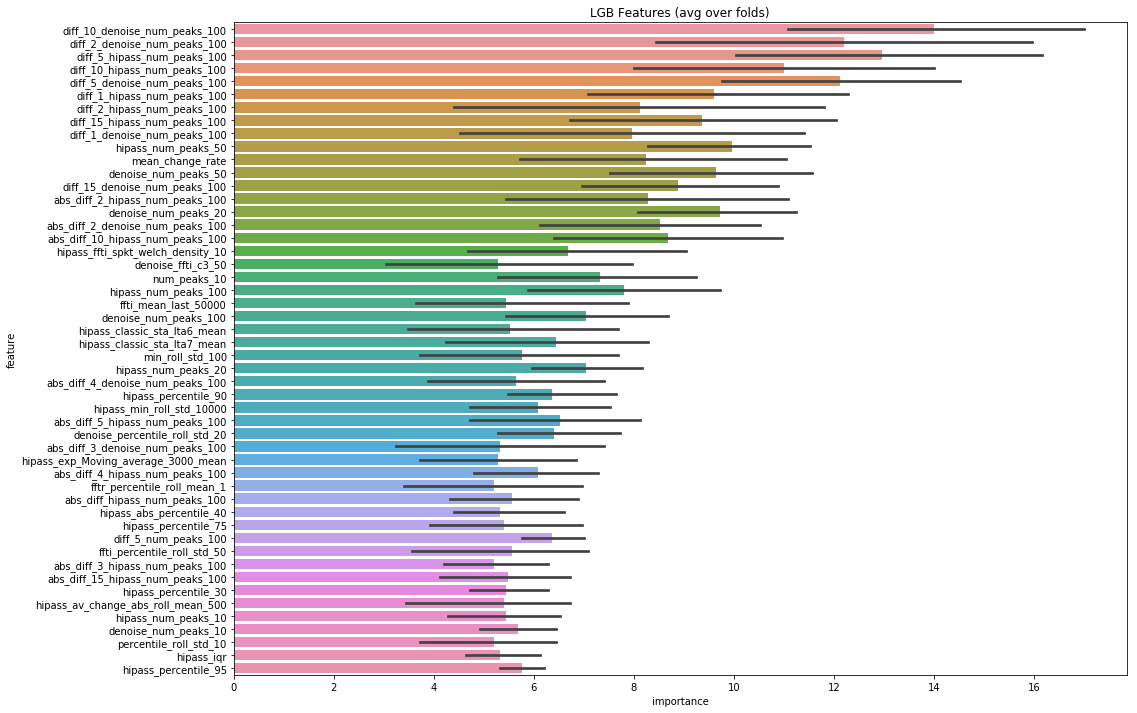

In [172]:
important_feature_cols = X.columns

params = {'num_leaves': 128,
          'min_data_in_leaf': 100,
          'objective': 'gamma',
          'max_depth': 8,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.81,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": 1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.7,
          'feature_fraction': 0.01
         }
oof_lgb, prediction_lgb, feature_importance = train_model(X[important_feature_cols],
                                                          X_test[important_feature_cols],
                                                          y,
                                                          params=params,
                                                          model_type='lgb',
                                                          plot_feature_importance=True)

In [150]:
important_feature_cols = list(feature_importance.groupby(by='feature')['importance'].mean().sort_values(ascending=False).index[:1000])

In [ ]:
# Memo
# Num Peaks の diff abs

(3000, 4000)

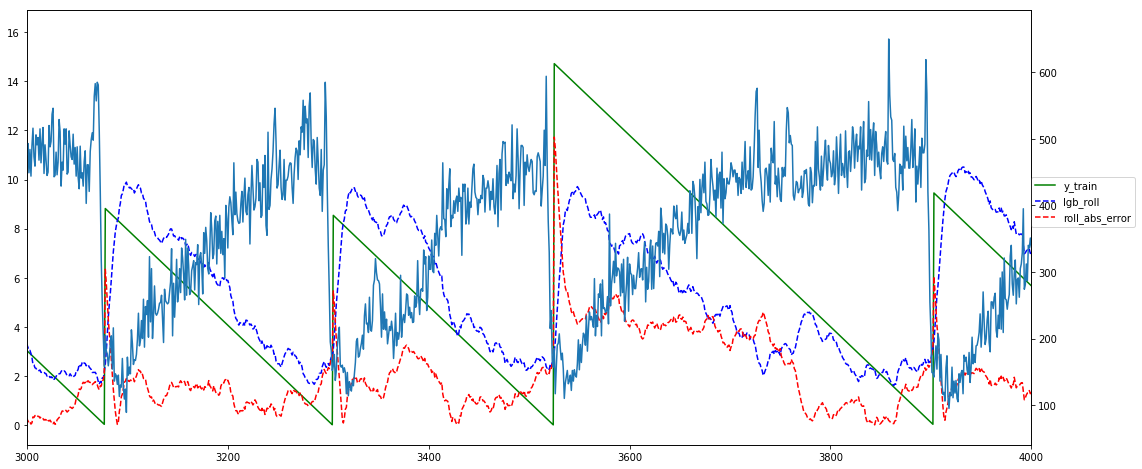

In [188]:
fig,ax = plt.subplots(figsize=(18, 8))
ax.plot(y, color='g', label='y_train')

#ax.plot(oof_lgb, color='b', label='lgb')

slgb_roll = pd.Series(oof_lgb).rolling(window=10).mean().fillna(0)
ax.plot(slgb_roll, color='b', label='lgb_roll', linestyle='--')

#ax.plot(np.abs(y - oof_lgb), color='r', label='abs_error')
ax.plot(np.abs(y - slgb_roll), color='r', label='roll_abs_error', linestyle='--')

ax2 = ax.twinx()
#ax2.plot(X['mean'], color='r', label='X_mean')
#ax2.plot(X['min'], label='X_mean')
#ax2.plot(X['max'], label='X_mean')
#ax2.plot(X['abs_diff_10_hipass_num_peaks_100'], label='X_mean')
ax2.plot(X['hipass_num_peaks_100'], label='X_mean')

ax.legend(loc=(1, 0.5));
ax.set_xlim(3000,4000)


#plt.title('lgb');

In [125]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_lgb
print(submission.head())
submission.to_csv('submission_20190501.csv')

              time_to_failure
seg_id                       
seg_00030f  2.821882279490967
seg_0012b5  5.134262072524937
seg_00184e  5.712854728770371
seg_003339  7.673419557724531
seg_0042cc  6.556272806669030


In [42]:
X.to_csv('train_features_hipass.csv', index=False)
X_test.to_csv('test_features_hipass.csv', index=False)
#pd.DataFrame(y).to_csv('y.csv', index=False)